In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geotiff_processor import GeotiffProcessor

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
north_geotiff_index = pd.read_csv('daily_northern_geotiff_index.csv', index_col=0)
north_geotiff_index.date = pd.to_datetime(north_geotiff_index.date, infer_datetime_format=True)

In [5]:
conc_index = north_geotiff_index.loc[north_geotiff_index.image_type == 'concentration']
ext_index = north_geotiff_index.loc[north_geotiff_index.image_type == 'extent']

In [6]:
conc_index = conc_index.set_index('date')
ext_index = ext_index.set_index('date')

In [7]:
conc_index.head()

,file_name,hemisphere,image_type
date,,,
1978-10-26,daily/geotiff/1978/N_19781026_concentration_v3...,north,concentration
1978-10-28,daily/geotiff/1978/N_19781028_concentration_v3...,north,concentration
1978-10-30,daily/geotiff/1978/N_19781030_concentration_v3...,north,concentration
1978-11-01,daily/geotiff/1978/N_19781101_concentration_v3...,north,concentration
1978-11-03,daily/geotiff/1978/N_19781103_concentration_v3...,north,concentration


In [8]:
ext_index.head()

,file_name,hemisphere,image_type
date,,,
1978-10-26,daily/geotiff/1978/N_19781026_extent_v3.0.tif,north,extent
1978-10-28,daily/geotiff/1978/N_19781028_extent_v3.0.tif,north,extent
1978-10-30,daily/geotiff/1978/N_19781030_extent_v3.0.tif,north,extent
1978-11-01,daily/geotiff/1978/N_19781101_extent_v3.0.tif,north,extent
1978-11-03,daily/geotiff/1978/N_19781103_extent_v3.0.tif,north,extent


In [9]:
conc_processor = GeotiffProcessor('raw_images/', conc_index)
ext_processor = GeotiffProcessor('raw_images/', ext_index)

In [10]:
conc_index_imputed = conc_processor.impute_missing_index_dates(set_this_index=True)
ext_index_imputed = ext_processor.impute_missing_index_dates(set_this_index=True)

----

In [11]:
ext_index_last_2 = conc_index_imputed.loc['2015-01-01':'2018-12-31']

In [12]:
ext_index_last_2

,file_name,hemisphere,image_type
date,,,
2015-01-01,daily/geotiff/2015/N_20150101_concentration_v3...,north,concentration
2015-01-02,daily/geotiff/2015/N_20150102_concentration_v3...,north,concentration
2015-01-03,daily/geotiff/2015/N_20150103_concentration_v3...,north,concentration
2015-01-04,daily/geotiff/2015/N_20150104_concentration_v3...,north,concentration
2015-01-05,daily/geotiff/2015/N_20150105_concentration_v3...,north,concentration
...,...,...,...
2018-12-27,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration


In [13]:
trim_processor = GeotiffProcessor('raw_images/', ext_index_last_2)

In [14]:
ext_last2 = trim_processor.process_images_keras_convlstm()

In [15]:
ext_last2.shape

(1, 1461, 1, 448, 304)

In [16]:
from keras.models import Sequential
import keras.backend as k

def mean_power_error(y_true, y_pred, p):
    diff = k.abs(y_true - y_pred)
    powered = diff ** p
    return k.mean(powered)

Using TensorFlow backend.


In [85]:
seq = Sequential()
seq.add(ConvLSTM2D(
    filters=1,
    kernel_size=(3,3),
    input_shape=(None, 1, 448, 304),
    data_format='channels_first',
    return_sequences=True,
    activation='tanh',
    padding='same'))

In [86]:
seq.compile(loss=lambda true, pred: mean_power_error(true, pred, 4), optimizer='adadelta')

In [87]:
x_train = ext_last2[:,:365,:,:,:]
y_train = ext_last2[:,1:366,:,:,:]

In [88]:
seq.fit(x_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 50s 50s/step - loss: 0.0054
Epoch 2/2
1/1 [==============================] - 50s 50s/step - loss: 0.0049


In [89]:
test_seq = ext_last2[:,10:30,:,:,:]

In [90]:
test_pred = seq.predict(test_seq)

In [91]:
test_frame = test_pred[:,15,:,:,:]

In [92]:
test_frame.shape

(1, 1, 448, 304)

In [30]:
trim_processor.load_default_colormaps('default_extent_colormap.pkl', 'default_concentration_colormap.pkl')

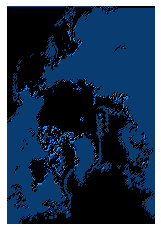

In [93]:
trim_processor.make_colored_prediction_image(test_frame, image_type='concentration')

In [20]:
trim_processor.image_index

,file_name,hemisphere,image_type
2017-01-01,daily/geotiff/2017/N_20170101_concentration_v3...,north,concentration
2017-01-02,daily/geotiff/2017/N_20170102_concentration_v3...,north,concentration
2017-01-03,daily/geotiff/2017/N_20170103_concentration_v3...,north,concentration
2017-01-04,daily/geotiff/2017/N_20170104_concentration_v3...,north,concentration
2017-01-05,daily/geotiff/2017/N_20170105_concentration_v3...,north,concentration
...,...,...,...
2018-12-27,daily/geotiff/2018/N_20181227_concentration_v3...,north,concentration
2018-12-28,daily/geotiff/2018/N_20181228_concentration_v3...,north,concentration
2018-12-29,daily/geotiff/2018/N_20181229_concentration_v3...,north,concentration
2018-12-30,daily/geotiff/2018/N_20181230_concentration_v3...,north,concentration


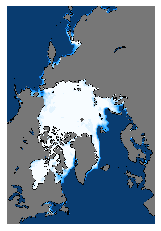

In [26]:
trim_processor.show_by_date('2018-01-01')

----

In [16]:
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM
from keras.layers import Flatten, Reshape, Permute
from keras.layers import TimeDistributed

In [18]:
conv_conc_images = trim_processor.process_images_keras_channels_first()

AttributeError: 'GeotiffProcessor' object has no attribute 'process_images_keras_conv2d'

In [245]:
x_train = conv_conc_images[:365,:,:,:]
y_train = conv_conc_images[1:366,:,:,:]

In [246]:
x_train.shape

(365, 1, 448, 304)

In [248]:
n_filters=4
seq2 = Sequential()
seq2.add(Conv2D(
    filters=n_filters,
    kernel_size=(5,5),
    strides=1,
    input_shape=(1, 448, 304),
    data_format='channels_first',
    activation='tanh',
    padding='same'))

In [249]:
seq2.compile(loss=lambda true, pred: mean_power_error(true, pred, 1), optimizer='adadelta')

In [250]:
seq2.fit(x_train, y_train, epochs=5)

Epoch 1/5
365/365 [==============================] - 16s 43ms/step - loss: 0.0661
Epoch 2/5
365/365 [==============================] - 16s 45ms/step - loss: 0.0408
Epoch 3/5
365/365 [==============================] - 17s 47ms/step - loss: 0.0235
Epoch 4/5
365/365 [==============================] - 19s 52ms/step - loss: 0.0170
Epoch 5/5
365/365 [==============================] - 21s 58ms/step - loss: 0.0162


In [252]:
test_frame = seq2.predict(conv_conc_images[365:730,:,:,:])

In [253]:
test_frame.shape

(365, 4, 448, 304)

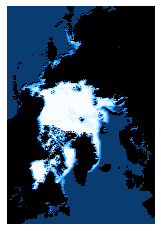

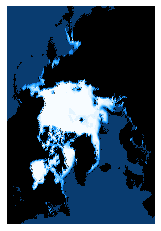

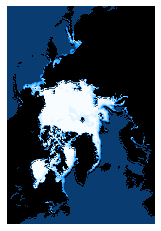

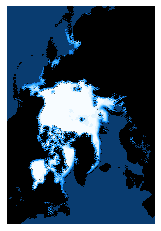

In [255]:
for i in range(seq2.output_shape[1]):
    frame = test_frame[-1,i,:,:]
    trim_processor.make_colored_prediction_image(frame, image_type='concentration').show()

----

In [17]:
from tcn import TCN

In [56]:
lstm_images = trim_processor.process_images_keras_lstm(normalize=False)

In [19]:
lstm_images.shape

(1, 1461, 136192)

In [61]:
x_train = lstm_images[:,:730,:]
y_train = lstm_images[:,10:740,:]

In [21]:
from keras.layers import Dense

In [35]:
lstm_seq = Sequential()

In [24]:
lstm_seq.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
lstm_seq.fit(x_train, y_train, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1/1 [==============================] - 866s 866s/step - loss: 0.0187


In [26]:
x_train.shape

(1, 365, 136192)

In [27]:
test_frames = lstm_images[:,370:400,:]

In [28]:
test_preds = lstm_seq.predict(test_frames)

In [29]:
test_frame = test_frames[:,-1,:]
test_pred = test_preds[:,-1,:]

In [30]:
test_frame.shape

(1, 136192)

In [31]:
test_frame = test_frame.reshape(1, 448, 304)
test_pred = test_pred.reshape(1, 448, 304)

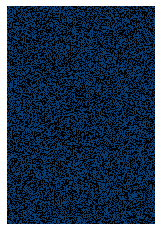

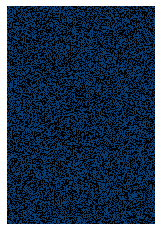

In [32]:
trim_processor.make_colored_prediction_image(test_pred, image_type='concentration')

In [74]:
tcn_seq = Sequential()
tcn_seq.add(TCN(input_shape=(None, 304*448), nb_filters=40, kernel_size=2, return_sequences=True, activation='tanh'))
tcn_seq.add(TCN(nb_filters=10, kernel_size=3, return_sequences=True, activation='relu'))
#tcn_seq.add(TCN(nb_filters=10, kernel_size=4, return_sequences=True, activation='tanh'))
#tcn_seq.add(TCN(nb_filters=10, kernel_size=5, return_sequences=True, activation='tanh'))
#tcn_seq.add(TCN(nb_filters=10, kernel_size=10, return_sequences=True, activation='tanh'))
tcn_seq.add(Dense(304*448, activation='relu'))

In [75]:
tcn_seq.compile(optimizer='adam', loss='mean_absolute_error')

In [77]:
tcn_seq.fit(x_train, y_train, epochs=10)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1392.4452
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 1382.1664
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 1379.5107
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 1377.1958
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 1375.0581
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 1374.7662
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 1374.4514
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 1373.9216
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 1374.1237
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: 1374.5050


In [78]:
test_seq = lstm_images[:,500:520,:]

In [79]:
tcn_preds = tcn_seq.predict(test_seq)

In [80]:
test_frame = tcn_preds[:,1,:]
test_frame = test_frame.reshape((test_frame.shape[0], 448, 304))
test_frame.shape

(1, 448, 304)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


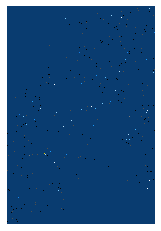

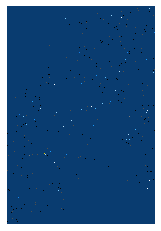

In [81]:
trim_processor.make_colored_prediction_image(test_frame, image_type='concentration', normed=False)

[[   96    42 65442 ... 65181 65223 65250]
 [   11   151 65143 ... 65292 65202 65277]
 [65415    41    28 ... 65064 65233 65001]
 ...
 [65316 65292 65242 ...   239 65417    13]
 [65165 65196 65293 ...    51 65491 65496]
 [65105 65070 65265 ... 65522 65346   270]]
[[   28 65503    36 ... 65352 65256 65346]
 [65473     3    76 ... 65277 65385 65292]
 [   25 65444 65464 ... 65280 65192 65333]
 ...
 [65248 65198 65253 ... 65444 65503 65389]
 [65203 65321 65192 ...    31 65507    94]
 [65214 65318 65298 ... 65512 65525     3]]
[[65406 65420    69 ... 65276 65230 65046]
 [65506 65510    66 ... 65110 65238 65239]
 [65497 65450    30 ... 65405 65165 65347]
 ...
 [65048 64835 64931 ...    26 65408 65407]
 [65067 65115 65219 ...    46    40   169]
 [64855 65140 65017 ...   122    37 65470]]
[[   27 65491 65527 ... 65366 65263 65146]
 [   64 65276 65515 ... 65268 65294 65435]
 [65292    65    98 ... 65473    27 65374]
 ...
 [65408 65191 65310 ...   103    11    18]
 [65369 65239 65465 ...     0 6

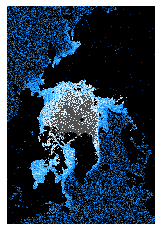

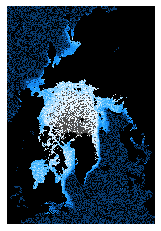

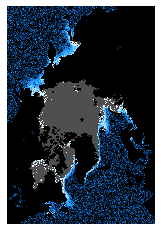

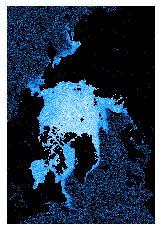

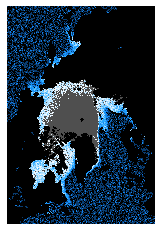

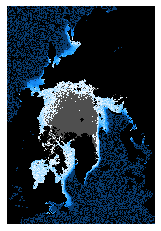

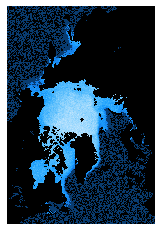

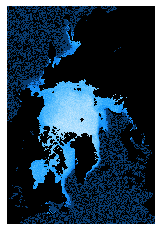

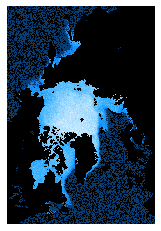

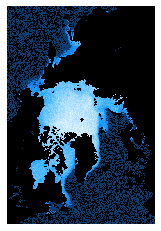

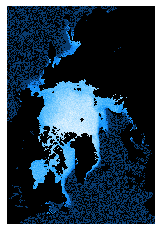

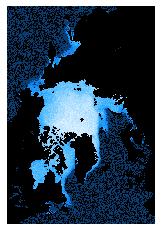

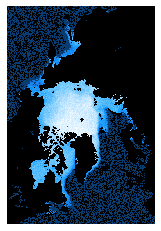

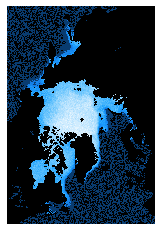

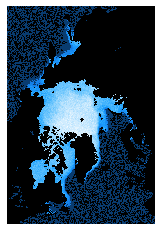

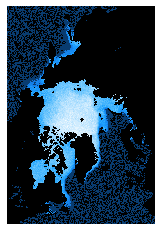

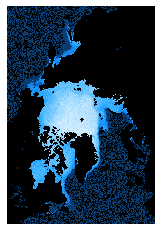

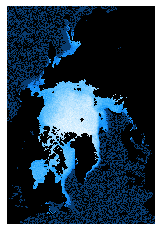

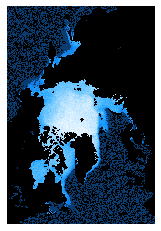

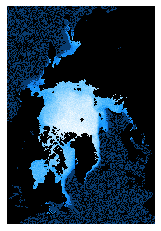

In [55]:
for i in range(tcn_preds.shape[1]):
    frame = tcn_preds[:,i,:]
    frame = frame.reshape(frame.shape[0], 448, 304)
    trim_processor.make_colored_prediction_image(frame, image_type='concentration')

In [190]:
trim_processor.default_concentration_cmap

{0: (9, 60, 112, 255),
 1: (9, 60, 112, 255),
 2: (9, 60, 112, 255),
 3: (9, 60, 112, 255),
 4: (9, 60, 112, 255),
 5: (9, 60, 112, 255),
 6: (9, 60, 112, 255),
 7: (9, 60, 112, 255),
 8: (9, 60, 112, 255),
 9: (9, 60, 112, 255),
 10: (9, 60, 112, 255),
 11: (9, 60, 112, 255),
 12: (9, 60, 112, 255),
 13: (9, 60, 112, 255),
 14: (9, 60, 112, 255),
 15: (9, 60, 112, 255),
 16: (9, 60, 112, 255),
 17: (9, 60, 112, 255),
 18: (9, 60, 112, 255),
 19: (9, 60, 112, 255),
 20: (9, 60, 112, 255),
 21: (9, 60, 112, 255),
 22: (9, 60, 112, 255),
 23: (9, 60, 112, 255),
 24: (9, 60, 112, 255),
 25: (9, 60, 112, 255),
 26: (9, 60, 112, 255),
 27: (9, 60, 112, 255),
 28: (9, 60, 112, 255),
 29: (9, 60, 112, 255),
 30: (9, 60, 112, 255),
 31: (9, 60, 112, 255),
 32: (9, 60, 112, 255),
 33: (9, 60, 112, 255),
 34: (9, 60, 112, 255),
 35: (9, 60, 112, 255),
 36: (9, 60, 112, 255),
 37: (9, 60, 112, 255),
 38: (9, 60, 112, 255),
 39: (9, 60, 112, 255),
 40: (9, 60, 112, 255),
 41: (9, 60, 112, 255),
 4